<a href="https://colab.research.google.com/github/leogalbu/Mineral-Rocks-Image-Classification/blob/Model_1_Quartz_Pyrite_Binary/Model_1_Quartz_Pyrite_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [4]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np

## Keras
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from keras import Sequential

## Download the data

In [5]:
!wget https://www.dropbox.com/s/dq4wf6crqg8ecqv/QuartzPyriteImages.rar

--2022-09-08 12:19:41--  https://www.dropbox.com/s/dq4wf6crqg8ecqv/QuartzPyriteImages.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dq4wf6crqg8ecqv/QuartzPyriteImages.rar [following]
--2022-09-08 12:19:42--  https://www.dropbox.com/s/raw/dq4wf6crqg8ecqv/QuartzPyriteImages.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0c2a997a13a207509567437b40.dl.dropboxusercontent.com/cd/0/inline/Bsh0HR6k_dZ5khh9WgmNm3trF4PLCD2U5F4dGeC2bCH_ZtQAxik1Gnv9zpeRIuBXpGyNzNopAQxOCFYvYzHmU6zSJU7JT6WajpfxHbPH2BUZOJXHDY5CZrbmjwHptrAYPF81v0mJTZgdM4FJn6mstMVcKcwU7xPMa4fDkj9ofD5KCQ/file# [following]
--2022-09-08 12:19:42--  https://uc0c2a997a13a207509567437b40.dl.dropboxusercontent.com/cd/0/inline/Bsh0HR6k_dZ5khh9WgmNm3trF4PLCD2U5F4dGeC2bCH_ZtQAxi

## Extract the dataset

In [6]:
!unrar x "/content/QuartzPyriteImages.rar" "/content/QuartzPyriteImages/";


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/QuartzPyriteImages.rar

Creating    /content/QuartzPyriteImages                               OK
Creating    /content/QuartzPyriteImages/train                         OK
Creating    /content/QuartzPyriteImages/train/Pyrite                  OK
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1.jpg          0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1002.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1004.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1005.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1007.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1008.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1011.jpg       0%  OK 
Extracting  /conten

## Setting the train, validation and test directory

In [7]:
train_dir = 'QuartzPyriteImages/train'
val_dir = 'QuartzPyriteImages/validation'
test_dir = 'QuartzPyriteImages/test'

## Scanning the directories (Before checking the correct images)

In [8]:
for dirpath, dirnames, filenames in os.walk('QuartzPyriteImages'):
  print(f"the are {len(dirnames)} directories, and {len(filenames)} images in '{dirpath}'")

the are 3 directories, and 0 images in 'QuartzPyriteImages'
the are 2 directories, and 0 images in 'QuartzPyriteImages/validation'
the are 0 directories, and 260 images in 'QuartzPyriteImages/validation/Pyrite'
the are 0 directories, and 238 images in 'QuartzPyriteImages/validation/Quartz'
the are 2 directories, and 0 images in 'QuartzPyriteImages/test'
the are 0 directories, and 260 images in 'QuartzPyriteImages/test/Pyrite'
the are 0 directories, and 238 images in 'QuartzPyriteImages/test/Quartz'
the are 2 directories, and 0 images in 'QuartzPyriteImages/train'
the are 0 directories, and 778 images in 'QuartzPyriteImages/train/Pyrite'
the are 0 directories, and 713 images in 'QuartzPyriteImages/train/Quartz'


## Scanning all the images and remove the not formatted well

In [9]:
from struct import unpack
from tqdm import tqdm_notebook
import pathlib
data_dir = [pathlib.Path(val_dir), pathlib.Path(train_dir), pathlib.Path(test_dir)]
data_dir

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                raise TypeError("issue reading jpeg file")       


bads = []
for dir in data_dir:
  print(dir)
  for img in tqdm_notebook(list(dir.glob('*/*.jpg'))):
      image = str(img)
      image = JPEG(image) 
      try:
          image.decode()   
      except:
          os.remove(img)
          bads.append(img)

QuartzPyriteImages/validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/498 [00:00<?, ?it/s]

QuartzPyriteImages/train


  0%|          | 0/1490 [00:00<?, ?it/s]

QuartzPyriteImages/test


  0%|          | 0/498 [00:00<?, ?it/s]

## Scanning the directories (After checking the correct images)

In [10]:
for dirpath, dirnames, filenames in os.walk('QuartzPyriteImages'):
  print(f"the are {len(dirnames)} directories, and {len(filenames)} images in '{dirpath}'")

the are 3 directories, and 0 images in 'QuartzPyriteImages'
the are 2 directories, and 0 images in 'QuartzPyriteImages/validation'
the are 0 directories, and 237 images in 'QuartzPyriteImages/validation/Pyrite'
the are 0 directories, and 236 images in 'QuartzPyriteImages/validation/Quartz'
the are 2 directories, and 0 images in 'QuartzPyriteImages/test'
the are 0 directories, and 240 images in 'QuartzPyriteImages/test/Pyrite'
the are 0 directories, and 236 images in 'QuartzPyriteImages/test/Quartz'
the are 2 directories, and 0 images in 'QuartzPyriteImages/train'
the are 0 directories, and 695 images in 'QuartzPyriteImages/train/Pyrite'
the are 0 directories, and 709 images in 'QuartzPyriteImages/train/Quartz'


## Loading Datasets with image_dataset_from_directory

In [11]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
print('Setting up Training data')
train_data_set = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')
print('Setting up Validation data')
validation_data_set = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')
print('Setting up Test data')
test_data_set = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')

Setting up Training data
Found 1403 files belonging to 2 classes.
Setting up Validation data
Found 473 files belonging to 2 classes.
Setting up Test data
Found 476 files belonging to 2 classes.


## View Random Image

In [12]:
class_names = train_data_set.class_names

def random_image_picker(target_dir, target_class):
  target_folder = target_dir + '/' + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  #print(f"Image shape: {img.shape}")

  return img

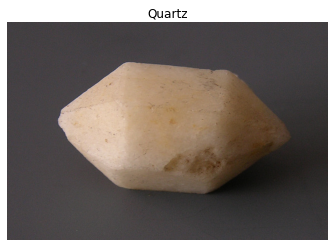

In [13]:
img = random_image_picker("QuartzPyriteImages/train", "Quartz")

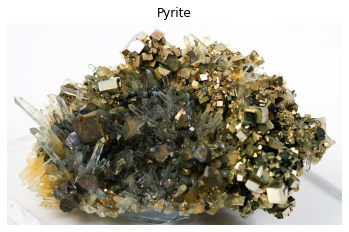

In [14]:
img = random_image_picker("QuartzPyriteImages/train", "Pyrite")

In [15]:
class_names = train_data_set.class_names
class_names


['Pyrite', 'Quartz']

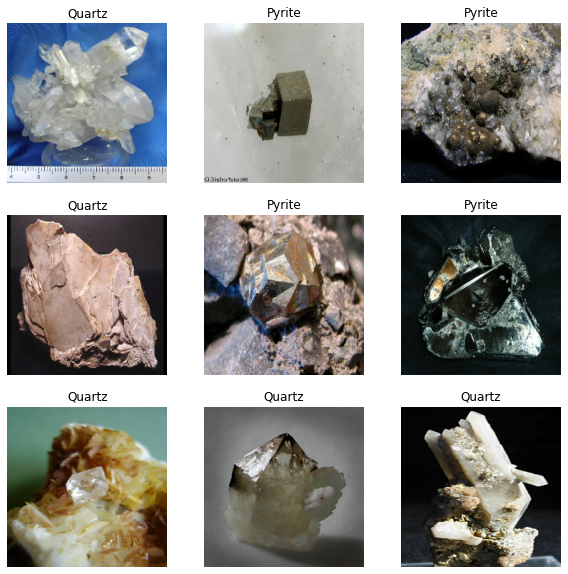

In [16]:
class_names = train_data_set.class_names
plt.figure(figsize=(10,10))
for images, labels in train_data_set.take(1):
  lbl = labels.numpy().ravel().astype('int')
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[lbl[i]])
    plt.axis('off')

## Build the Base CNN Model from Scratch (No data augmentation)

In [17]:
from tensorflow.keras.layers.experimental import preprocessing

model_1_baseline = Sequential([
    tf.keras.layers.Rescaling(1./255),
    Conv2D(32,3, input_shape=(224,224,3), activation='relu'),
    MaxPool2D(),
    Conv2D(64,3,activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(256,3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [18]:
# Compile the model
model_1_baseline.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

In [19]:
# Fit the Model
history_1_baseline = model_1_baseline.fit(train_data_set, epochs=20, steps_per_epoch=len(train_data_set), validation_data=test_data_set, validation_steps=len(test_data_set))

Epoch 1/20
44/44 [==============================] - 20s 153ms/step - loss: 0.6769 - accuracy: 0.6443 - val_loss: 0.5396 - val_accuracy: 0.7395
Epoch 2/20
44/44 [==============================] - 6s 128ms/step - loss: 0.5115 - accuracy: 0.7555 - val_loss: 0.4254 - val_accuracy: 0.8172
Epoch 3/20
44/44 [==============================] - 6s 128ms/step - loss: 0.4050 - accuracy: 0.8239 - val_loss: 0.4502 - val_accuracy: 0.7920
Epoch 4/20
44/44 [==============================] - 6s 128ms/step - loss: 0.4009 - accuracy: 0.8304 - val_loss: 0.3579 - val_accuracy: 0.8529
Epoch 5/20
44/44 [==============================] - 7s 149ms/step - loss: 0.3605 - accuracy: 0.8489 - val_loss: 0.3489 - val_accuracy: 0.8487
Epoch 6/20
44/44 [==============================] - 6s 130ms/step - loss: 0.3562 - accuracy: 0.8411 - val_loss: 0.3238 - val_accuracy: 0.8676
Epoch 7/20
44/44 [==============================] - 6s 130ms/step - loss: 0.3393 - accuracy: 0.8560 - val_loss: 0.3567 - val_accuracy: 0.8424
Epoch

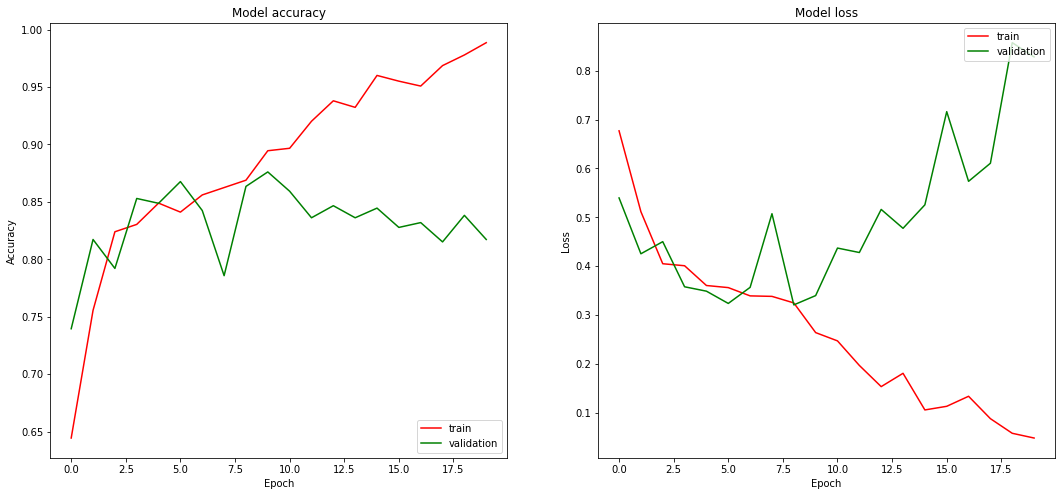

In [20]:
def plot_performance(model_history):
    # modle performance visualization
    # subplot
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # accuracy
    ax1.plot(model_history.history['accuracy'], color='red')
    ax1.plot(model_history.history['val_accuracy'], color='green')
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    # "Loss"
    ax2.plot(model_history.history['loss'], color='red')
    ax2.plot(model_history.history['val_loss'], color='green')
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
plot_performance(history_1_baseline)

In [21]:
model_1_baseline.evaluate(test_data_set)

15/15 [==============================] - 2s 57ms/step - loss: 0.8281 - accuracy: 0.8172


[0.8280676603317261, 0.8172268867492676]

In [22]:
class_names

['Pyrite', 'Quartz']

In [23]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img.numpy().astype(int)
  return img

In [24]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]
  print(pred_class)

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [25]:
pred_and_plot(model_1_baseline, "pyrite.jpg", class_names)

NotFoundError: ignored

[[1.]]
Quartz


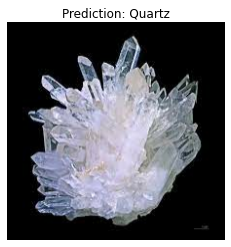

In [29]:
pred_and_plot(model_1_baseline, "qz.jpg", class_names)

[[0.00846845]]
Pyrite


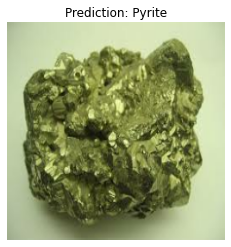

In [28]:
pred_and_plot(model_1_baseline, "pyrite_3.jpg", class_names)

In [26]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


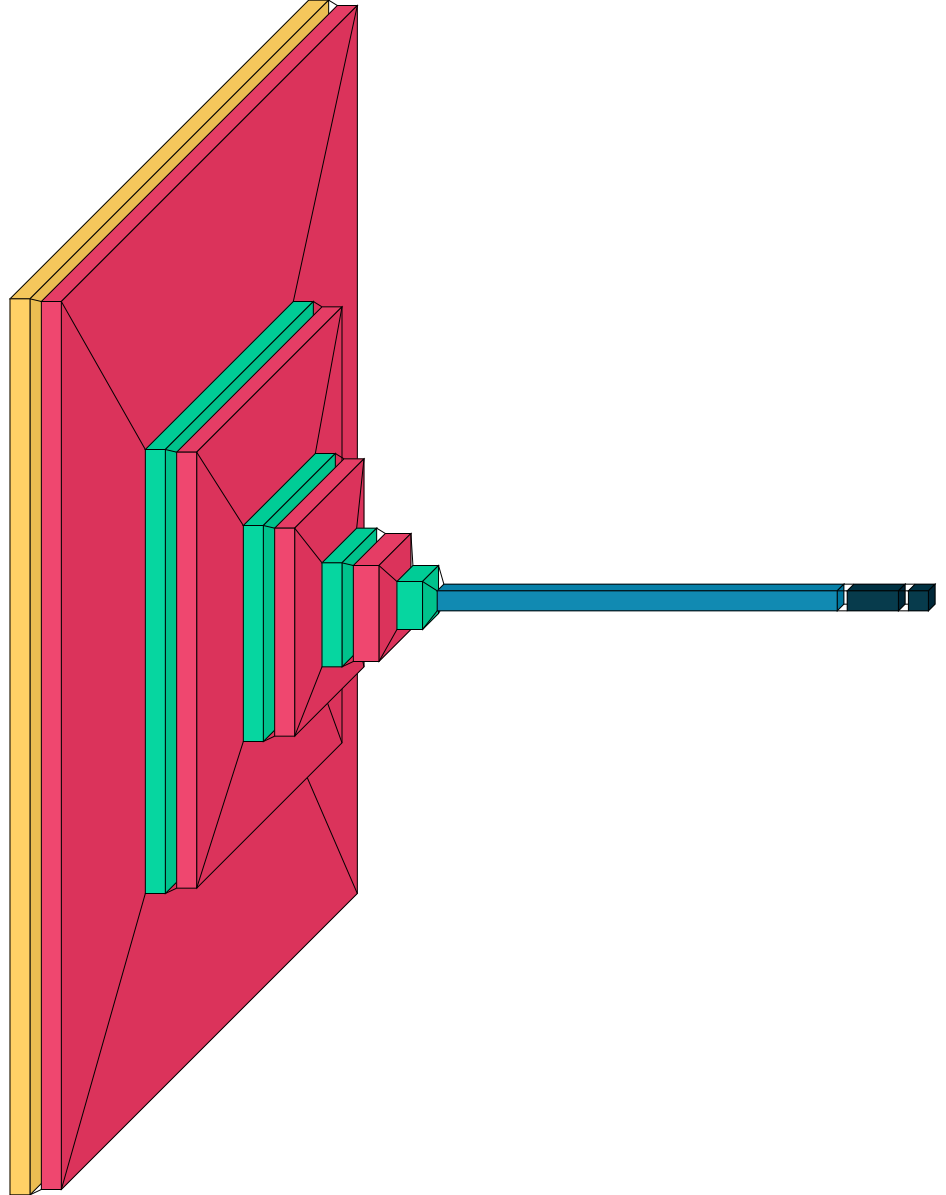

In [27]:
visualkeras.layered_view(model_1_baseline).show() # display using your system viewer

visualkeras.layered_view(model_1_baseline)